**Goal**: run multiple experiments with different YAML configs & log results.

In [1]:
%load_ext autoreload
%autoreload 2

Cell 1 – imports & helpers

In [3]:
import sys
from pathlib import Path
import json
import pandas as pd

import yaml
import numpy as np

import os

# Silence TF warnings (if TF is imported indirectly)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Robust project root resolver
def find_project_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / 'configs' / 'base.yaml').exists() and (p / 'src').exists():
            return p
    raise FileNotFoundError('Could not locate project root (expected configs/base.yaml and src/)')


PROJECT_ROOT = find_project_root(Path.cwd())

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('PROJECT_ROOT:', PROJECT_ROOT)

from src.data.load import load_all_sources, add_broad_category, load_yaml
from src.models.classifier import train_text_classifier
from src.models.evaluation import evaluate_classifier

EXPERIMENTS_DIR = PROJECT_ROOT / 'experiments' / 'results'
EXPERIMENTS_DIR.mkdir(parents=True, exist_ok=True)
print('Experiments output dir:', EXPERIMENTS_DIR)

PROJECT_ROOT: /home/spark/NUST/Semester 5/Data Mining/Project
Experiments output dir: /home/spark/NUST/Semester 5/Data Mining/Project/experiments/results


Cell 2 – config loader and experiment function

In [4]:
def run_experiment(config_path: Path, experiment_name: str) -> tuple:
    cfg = load_yaml(config_path)
    print(f'Running experiment: {experiment_name}')
    print(f'Using config: {config_path}')

    df = load_all_sources(cfg, root=PROJECT_ROOT)
    df = add_broad_category(df, cfg, root=PROJECT_ROOT)

    # (optional) filter to categories with enough samples
    min_samples = cfg['categories'].get('min_samples_per_class', 0)
    if min_samples > 0:
        counts = df['broad_category'].value_counts()
        keep_cats = counts[counts >= min_samples].index.tolist()
        df = df[df['broad_category'].isin(keep_cats)]
        print('Kept categories:', keep_cats)

    model, X_train, X_test, y_train, y_test, _ = train_text_classifier(df, cfg)

    from sklearn.metrics import classification_report
    y_pred = model.predict(X_test)

    metrics = evaluate_classifier(y_test, y_pred)
    print('Accuracy:', metrics['accuracy'])
    print('Macro F1:', metrics['macro_f1'])

    # Save metrics to JSON
    result = {
        'experiment_name': experiment_name,
        'config_path': str(config_path),
        'accuracy': metrics['accuracy'],
        'macro_f1': metrics['macro_f1'],
        'labels': metrics['labels'],
        'classification_report': metrics['classification_report'],
    }

    # Save inside a sub-directory named after the experiment
    exp_sub_dir = EXPERIMENTS_DIR / experiment_name
    exp_sub_dir.mkdir(parents=True, exist_ok=True)
    out_path = exp_sub_dir / 'metrics.json'
    with out_path.open('w', encoding='utf-8') as f:
        json.dump(result, f, indent=2)

    return model, result


Cell 3 – run a few experiments

In [6]:
# --- CONFIGURATION SECTION ---
configs_to_run = [
    'tfidf_logreg_basic.yaml',  # Baseline: No cleaning
    'tfidf_logreg_clean.yaml',  # Test: Effect of cleaning
    'bow_logreg_clean.yaml',  # Test: BoW vs TF-IDF
    'tfidf_svm_clean.yaml',  # Test: Model (LogReg vs SVM)
    'tfidf_nb_clean.yaml',  # Test: Model (Naive Bayes)
    'tfidf_svm_bigrams.yaml',  # Test: Context (Unigrams vs Bigrams)
    'bow_svm_clean.yaml',  # Test: Model (SVM with BoW)
]

print('Configs to run:', configs_to_run)

Configs to run: ['tfidf_logreg_basic.yaml', 'tfidf_logreg_clean.yaml', 'bow_logreg_clean.yaml', 'tfidf_svm_clean.yaml', 'tfidf_nb_clean.yaml', 'tfidf_svm_bigrams.yaml', 'bow_svm_clean.yaml']


In [7]:
results = []
models = []

for config_name in configs_to_run:
    config_path = PROJECT_ROOT / 'configs' / config_name

    # Use the filename (without .yaml) as the experiment name for directory naming
    experiment_id = config_path.stem

    # Create a unique output directory for this specific configuration
    exp_output_dir = EXPERIMENTS_DIR / experiment_id
    exp_output_dir.mkdir(parents=True, exist_ok=True)

    print(f'\n' + '=' * 50)
    print(f'STARTING EXPERIMENT: {experiment_id}')
    print(f'=' * 50)

    try:
        # Run the experiment
        model, result = run_experiment(config_path, experiment_name=experiment_id)

        # Save model and artifacts into the specific experiment folder
        from src.models.classifier import save_classifier

        save_classifier(model, load_yaml(config_path), root=PROJECT_ROOT)

        models.append(model)
        results.append(result)

    except Exception as e:
        print(f'!!! Error running {config_name}: {e}')

# Display high-level summary of all runs in this session
pd.DataFrame([
    {'Experiment': r['experiment_name'], 'Accuracy': r['accuracy'], 'Macro F1': r['macro_f1']}
    for r in results
])

INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)



STARTING EXPERIMENT: tfidf_logreg_basic
Running experiment: tfidf_logreg_basic
Using config: /home/spark/NUST/Semester 5/Data Mining/Project/configs/tfidf_logreg_basic.yaml


INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/src/data/load.py:143: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas th

Kept categories: ['Pakistan', 'World', 'Business', 'Sports', 'Lifestyle', 'Opinion']
Accuracy: 0.8532133676092545
Macro F1: 0.8407238029668981


INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)



STARTING EXPERIMENT: tfidf_logreg_clean
Running experiment: tfidf_logreg_clean
Using config: /home/spark/NUST/Semester 5/Data Mining/Project/configs/tfidf_logreg_clean.yaml


INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/src/data/load.py:143: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas th

Kept categories: ['Pakistan', 'World', 'Business', 'Sports', 'Lifestyle', 'Opinion']
Accuracy: 0.8573264781491002
Macro F1: 0.8391403263835372


INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)



STARTING EXPERIMENT: bow_logreg_clean
Running experiment: bow_logreg_clean
Using config: /home/spark/NUST/Semester 5/Data Mining/Project/configs/bow_logreg_clean.yaml


INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/src/data/load.py:143: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas th

Kept categories: ['Pakistan', 'World', 'Business', 'Sports', 'Lifestyle', 'Opinion']
Accuracy: 0.8448586118251928
Macro F1: 0.8327281746450118


INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)



STARTING EXPERIMENT: tfidf_svm_clean
Running experiment: tfidf_svm_clean
Using config: /home/spark/NUST/Semester 5/Data Mining/Project/configs/tfidf_svm_clean.yaml


INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/src/data/load.py:143: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas th

Kept categories: ['Pakistan', 'World', 'Business', 'Sports', 'Lifestyle', 'Opinion']
Accuracy: 0.8584832904884319
Macro F1: 0.8445513965741781


INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)



STARTING EXPERIMENT: tfidf_nb_clean
Running experiment: tfidf_nb_clean
Using config: /home/spark/NUST/Semester 5/Data Mining/Project/configs/tfidf_nb_clean.yaml


INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/src/data/load.py:143: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas th

Kept categories: ['Pakistan', 'World', 'Business', 'Sports', 'Lifestyle', 'Opinion']
Accuracy: 0.8546272493573265
Macro F1: 0.8411005393652973


INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)



STARTING EXPERIMENT: tfidf_svm_bigrams
Running experiment: tfidf_svm_bigrams
Using config: /home/spark/NUST/Semester 5/Data Mining/Project/configs/tfidf_svm_bigrams.yaml


INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/src/data/load.py:143: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas th

Kept categories: ['Pakistan', 'World', 'Business', 'Sports', 'Lifestyle', 'Opinion']
Accuracy: 0.8663239074550129
Macro F1: 0.8497418474186215


INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)



STARTING EXPERIMENT: bow_svm_clean
Running experiment: bow_svm_clean
Using config: /home/spark/NUST/Semester 5/Data Mining/Project/configs/bow_svm_clean.yaml


INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/src/data/load.py:143: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas th

Kept categories: ['Pakistan', 'World', 'Business', 'Sports', 'Lifestyle', 'Opinion']
Accuracy: 0.849228791773779
Macro F1: 0.8361921100072829


,Experiment,Accuracy,Macro F1
0,tfidf_logreg_basic,0.853213,0.840724
1,tfidf_logreg_clean,0.857326,0.839140
2,bow_logreg_clean,0.844859,0.832728
3,tfidf_svm_clean,0.858483,0.844551
4,tfidf_nb_clean,0.854627,0.841101
5,tfidf_svm_bigrams,0.866324,0.849742
6,bow_svm_clean,0.849229,0.836192


In [8]:
import numpy as np

if results:
    # 1. Identify the best model based on accuracy
    best_index = np.argmax([r['accuracy'] for r in results])
    best_model = models[best_index]
    best_exp_name = results[best_index]['experiment_name']

    print(f'Best Model Found: {best_exp_name} ({results[best_index]['accuracy']:.4f} accuracy)')

    # 2. Generate a global comparison CSV
    df_results = pd.DataFrame([
        {'experiment': r['experiment_name'], 'accuracy': r['accuracy'], 'macro_f1': r['macro_f1']}
        for r in results
    ]).sort_values('macro_f1', ascending=False)

    df_results.to_csv(EXPERIMENTS_DIR / 'latest_model_comparison.csv', index=False)

    # 3. Save a 'best_model.txt' in the root results dir to track which one won
    with open(EXPERIMENTS_DIR / 'best_model_run.txt', 'w') as f:
        f.write(f'Best Run: {best_exp_name}\nAccuracy: {results[best_index]['accuracy']}')
else:
    print('No results found. Check if your YAML list is empty or paths are incorrect.')

Best Model Found: tfidf_svm_bigrams (0.8663 accuracy)


Cell 4 – compare experiments

In [10]:
out_dir = PROJECT_ROOT / 'experiments' / 'results'
out_dir.mkdir(parents=True, exist_ok=True)

df_results = pd.DataFrame([
    {'experiment': r['experiment_name'], 'accuracy': r['accuracy'], 'macro_f1': r['macro_f1']}
    for r in results
]).sort_values('macro_f1', ascending=False)

df_results.to_csv(out_dir / 'model_comparison.csv', index=False)
df_results


,experiment,accuracy,macro_f1
5,tfidf_svm_bigrams,0.866324,0.849742
3,tfidf_svm_clean,0.858483,0.844551
4,tfidf_nb_clean,0.854627,0.841101
0,tfidf_logreg_basic,0.853213,0.840724
1,tfidf_logreg_clean,0.857326,0.839140
6,bow_svm_clean,0.849229,0.836192
2,bow_logreg_clean,0.844859,0.832728


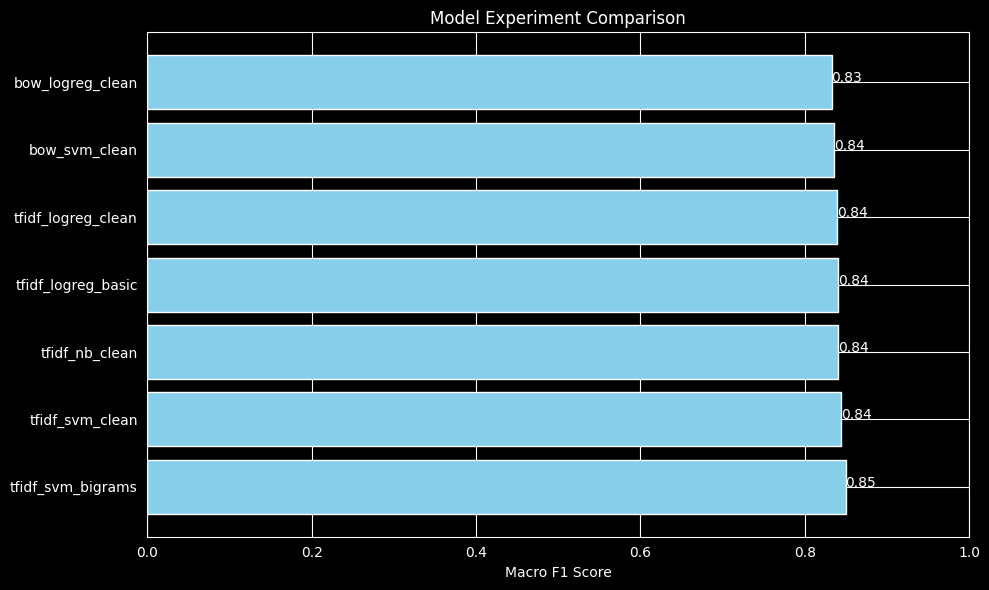

In [11]:
# Graphical comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(df_results['experiment'], df_results['macro_f1'], color='skyblue')
plt.xlabel('Macro F1 Score')
plt.title('Model Experiment Comparison')
plt.xlim(0, 1)
for index, value in enumerate(df_results['macro_f1']):
    plt.text(value, index, f'{value:.2f}')
plt.tight_layout()
plt.show()